<a href="https://colab.research.google.com/github/Rajayogi/rajayogi/blob/master/food_classifier_101_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multiclass Classification using Keras and TensorFlow on Food-101 Dataset  
![alt text](https://www.vision.ee.ethz.ch/datasets_extra/food-101/static/img/food-101.jpg)

**Food-101 Dataset** - https://www.vision.ee.ethz.ch/datasets_extra/food-101/

_Notebook orignially contributed by: [Avinash Kappa](https://theimgclist.github.io/)_

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/multi_class_classification/food_classifier.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/community/en/multi_class_classification/food_classifier.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Install TensorFlow 2.0 Preview

* TensorFlow 2.0 preview is available to test
* Colab is the easiest way to try it
* We can install TensorFlow 2.0 Preview using the below code cell

In [0]:
# Uncomment the below line of code if you want to try TensorFlow v2.0
#!pip install tf-nightly-gpu-2.0-preview

* Upgrading to TF 2.0 will be a critical process if you already have projects/code in other TF versions
* tf_upgrade_v2 tool helps in converting existing TF code to TF 2.0
* This tool is automatically installed by pip install for TensorFlow 1.13 and later
* Below is an example of how to use this tool:

`tf_upgrade_v2 --infile script.py --outfile script-upgraded.py`

# Download and extract Food 101 Dataset

* Add all the imports

In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [2]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

1.13.1
/device:GPU:0


In [3]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 2198 (delta 18), reused 59 (delta 6), pack-reused 2123
Receiving objects: 100% (2198/2198), 8.33 MiB | 16.22 MiB/s, done.
Resolving deltas: 100% (1040/1040), done.


In [0]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

* The Food-101 dataset is 5GB in size. This might take some time to finish..

In [5]:
# Download data and extract it to folder
get_data_extract()

4996284416/4996278331 [==============================] - 843s 0us/step
Dataset downloaded and extracted!


# Understand dataset structure and files 

* The dataset being used is [Food 101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)
* This dataset has 101000 images in total. It's a food dataset with 101 categories(multiclass)
* Each type of food has 750 training samples and 250 test samples
* Note found on the webpage of the dataset :  
* On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
* The entire dataset is 5GB in size

In [6]:
# Check the extracted dataset folder
os.listdir('food-101/')

['license_agreement.txt', 'meta', 'README.txt', 'images']

**images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class

In [7]:
os.listdir('food-101/images')

['macaroni_and_cheese',
 'baby_back_ribs',
 'french_fries',
 'samosa',
 'ramen',
 'huevos_rancheros',
 'pad_thai',
 'ice_cream',
 'gnocchi',
 'takoyaki',
 'pho',
 'shrimp_and_grits',
 'spaghetti_bolognese',
 'pork_chop',
 'deviled_eggs',
 'chicken_quesadilla',
 'chocolate_mousse',
 'steak',
 'baklava',
 'grilled_salmon',
 'paella',
 'fried_calamari',
 'panna_cotta',
 'breakfast_burrito',
 'lobster_bisque',
 'falafel',
 'peking_duck',
 'lasagna',
 'grilled_cheese_sandwich',
 'beignets',
 'oysters',
 'seaweed_salad',
 'spaghetti_carbonara',
 'filet_mignon',
 'chicken_curry',
 'bruschetta',
 'clam_chowder',
 'creme_brulee',
 'cannoli',
 'ravioli',
 'scallops',
 'edamame',
 'escargots',
 'apple_pie',
 'garlic_bread',
 'cheese_plate',
 'nachos',
 'spring_rolls',
 'lobster_roll_sandwich',
 'donuts',
 'beet_salad',
 'pancakes',
 'croque_madame',
 'chicken_wings',
 'macarons',
 'tuna_tartare',
 'frozen_yogurt',
 'tacos',
 'hamburger',
 'red_velvet_cake',
 'risotto',
 'fish_and_chips',
 'gyoza'

**meta** folder contains the text files - train.txt and test.txt  
**train.txt** contains the list of images that belong to training set  
**test.txt** contains the list of images that belong to test set  
**classes.txt** contains the list of all classes of food

In [8]:
os.listdir('food-101/meta')

['train.json',
 'test.txt',
 'test.json',
 'train.txt',
 'labels.txt',
 'classes.txt']

# Visualize random image from each of the 101 classes

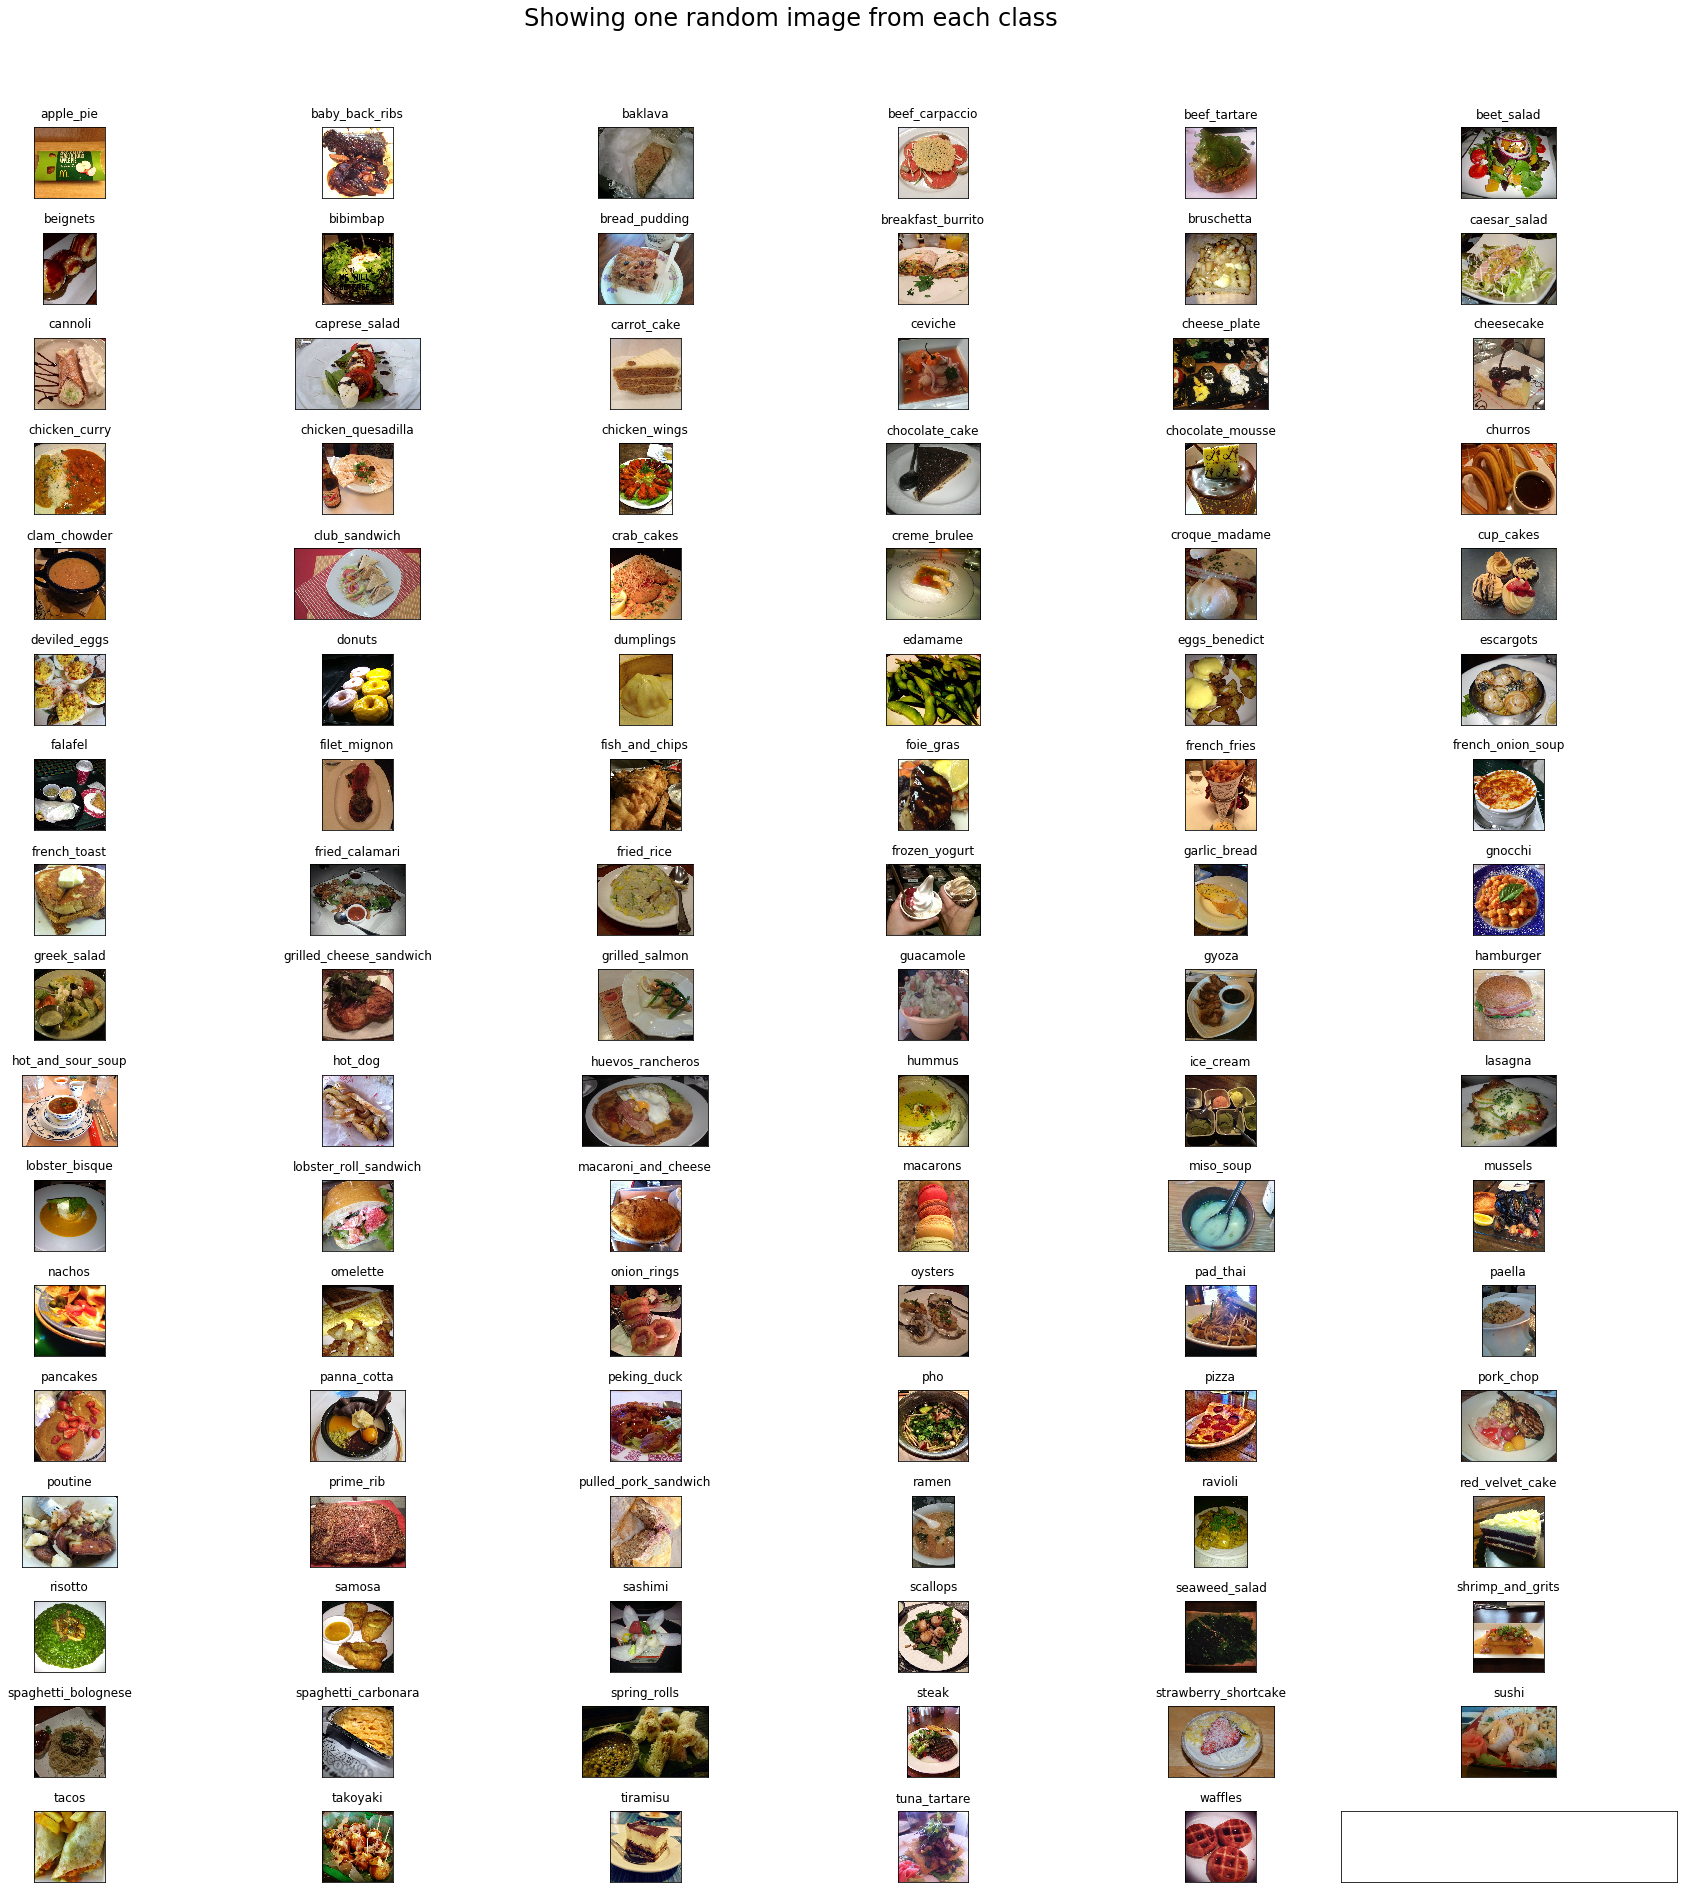

In [9]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


# Split the image data into train and test using train.txt and test.txt

In [0]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [11]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [12]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [13]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [14]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


# Create a subset of data with few classes (3)

* We now have train and test data ready  
* But to experiment and try different architectures, working on the whole data with 101 classes takes a lot of time and computation  
* To proceed with further experiments, I am creating train_min and test_mini, limiting the dataset to 3 classes  
* Since the original problem is multiclass classification which makes key aspects of architectural decisions different from that of binary classification, choosing 3 classes is a good start instead of 2

In [15]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [0]:
# picking 3 food items and generating separate data folders for the same
food_list = ['samosa','pizza','omelette']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [17]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print(train_files)

Total number of samples in train folder
75750


In [18]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print(test_files)

Total number of samples in test folder
25250


# Fine tune Inception Pretrained model using Food 101 dataset

* Keras and other Deep Learning libraries provide pretrained models  
* These are deep neural networks with efficient architectures(like VGG,Inception,ResNet) that are already trained on datasets like ImageNet  
* Using these pretrained models, we can use the already learned weights and add few layers on top to finetune the model to our new data  
* This helps in faster convergance and saves time and computation when compared to models trained from scratch

* We currently have a subset of dataset with 3 classes - samosa, pizza and omelette  
* Use the below code to finetune Inceptionv3 pretrained model

In [0]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'food-101/train'
  validation_data_dir = 'food-101/test'
  batch_size = 8
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [20]:
# Train the model with data from 3 classes
n_classes = 101
epochs = 7
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_101 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_101)

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.
Instructions for updating:
Colocations handled automatically by placer.
87916544/87910968 [==============================] - 3s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/7
3157/3157 [==============================] - 351s 111ms/step - loss: 2.7843 - acc: 0.4693

Epoch 00001: val_loss improved from inf to 2.78432, saving model to bestmodel_101class.hdf5
9469/9469 [==============================] - 3563s 376ms/step - loss: 4.3939 - acc: 0.1551 - val_loss: 2.7843 - val_acc: 0.4693
Epoch 2/7
3157/3157 [==============================] - 350s 111ms/step - loss: 1.8528 - acc: 0.6408

Epoch 00002: val_loss improved from 2.78432 to 1.85285, saving model to bestmodel_101class.hdf5
9469/9469 [==============================] - 3485s 368ms/step - loss: 3.0159 - acc: 0.3968 -

In [37]:
print(history.history.keys())
print(history.history['loss'])
print(history.history['acc'])
print(history.history['val_loss'])
print(history.history['val_acc'])

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])
[4.3938840357462565, 3.0159428875800405, 2.4255420078869308, 2.087545858427243, 1.870124043452071, 1.6946712863972477, 1.5618017124893642]
[0.15512872, 0.39676568, 0.5151683, 0.58446205, 0.62376237, 0.65951157, 0.6858614]
[2.7843234502404486, 1.8528470956414493, 1.5118996038971575, 1.3791130988949796, 1.2444274902985675, 1.1275831194553791, 1.0882259140220065]
[0.46930692, 0.6407525, 0.7085941, 0.730297, 0.7562772, 0.77873266, 0.78344554]


# Visualize the accuracy and loss plots

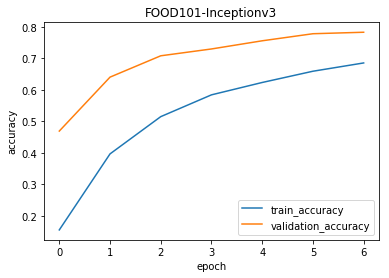

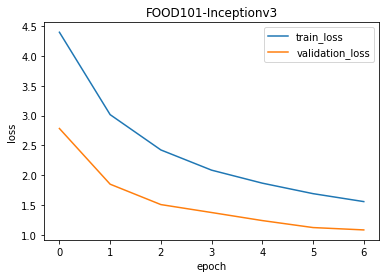

In [29]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_acc']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

* The plots show that the accuracy of the model increased with epochs and the loss has decreased
* Validation accuracy has been on the higher side than training accuracy for many epochs
* This could be for several reasons:
  * We used a pretrained model trained on ImageNet which contains data from a variety of classes
  * Using dropout can lead to a higher validation accuracy
* The best model saved has a Top-1 validation accuracy of 93%
 


# Predicting classes for new images from internet using the best trained model

In [43]:
%%time
# Loading the best saved model to make predictions

K.clear_session()
model_best = load_model('bestmodel_101class.hdf5',compile = False)

CPU times: user 8.55 s, sys: 213 ms, total: 8.76 s
Wall time: 8.73 s


* **Setting compile=False and clearing the session leads to faster loading of the saved model**
* **Withouth the above addiitons, model loading was taking more than a minute!**

In [0]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    #pred_value = food_list[index]
    print(foods_sorted[index])
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        #plt.title(pred_value)
        plt.show()
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


samosa


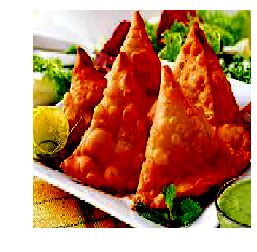

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


pizza


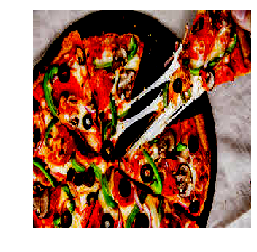

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


garlic_bread


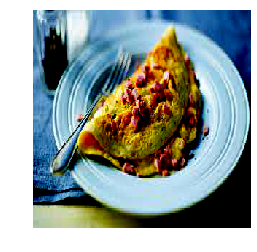

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


apple_pie


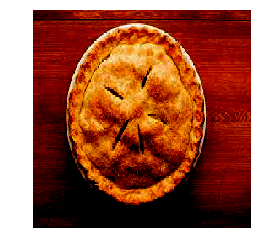

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


donuts


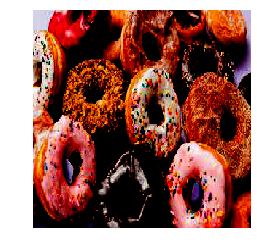

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


nachos


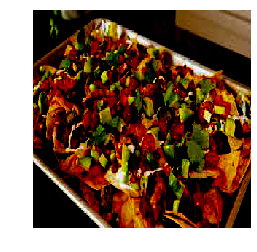

In [65]:
images = []
images.append('samosa.jpeg')
images.append('pizza.jpeg')
images.append('omlette.jpeg')
images.append('applipie.jpeg')
images.append('donuts.jpg')
images.append('nachos.jpeg')
predict_class(model_best, images, True)

The model got them all right!